# Packages

In [1]:
# Importando bibliotecas
import pydicom
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import os
import glob
import time
import torch
import matplotlib.pyplot as plt
#import glob
import torchvision.transforms.functional as TF
from torchvision.models import densenet121, vgg16, resnet50, inception_v3

from efficientnet_pytorch import EfficientNet
import copy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from skimage import io, transform
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tensorboardX import SummaryWriter

from common.myfunctions import plot_confusion_matrix
from common.customloss import QuadraticKappa, WeightedMultiLabelLogLoss

%matplotlib inline

# Parameters

In [2]:
BASE_DIR = '/srv/app/data'

DATA_DIR = BASE_DIR + '/data'

MODEL_DIR = BASE_DIR + '/models'

TRAIN_DIR = DATA_DIR + '/numpy_array/stage_1_train_images_299'
TEST_DIR = DATA_DIR + '/numpy_array/stage_1_train_images_299' #Same path because we split train in train and test.

TRAIN_LABELS = DATA_DIR + '/stage_1_train_pivoted.csv'
TEST_LABELS = DATA_DIR + ''

BATCH_SIZE = 224

NUM_EPOCH = 30

TEST_SPLIT = 0.3

SEED = 42

NUM_CLASSES = 6

LABEL_COLUMN = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

INPUT_SIZE = 299

IMAGE_FORMAT = 'npy'

MODELS = ['FineTuningResNet50']

OPTIMIZERS = ['DefaultAdam']

LOSSES = ['WeightedMultiLabelLogLoss']

SAMPLE_FRAC = 0.5 #Fraction of dataset to use. Set to 1.0 to use the entire dataset.

In [3]:
MODEL_LIST = {
    'PreDensenet121': {
        'base_model': 'densenet121',
        'is_inception': False,
        'pretrained': True,
        'load_checkpoint': False,
        'checkpoint_from': '',
        'layers_to_frozen': ['conv0', 'norm0', 'denseblock1', 'transition1', 
                             'denseblock2', 'transition2', 'denseblock3', 'transition3', 
                             'denseblock4', 'norm5']
    },
    'FineTuningDensenet121': {
        'base_model': 'densenet121',
        'is_inception': False,
        'pretrained': True,
        'load_checkpoint': False,
        'checkpoint_from': '',
        'layers_to_frozen': []
    },
    'FineTuningDensenet121v1': {
        'base_model': 'densenet121',
        'is_inception': False,
        'pretrained': True,
        'load_checkpoint': False,
        'checkpoint_from': '',
        'layers_to_frozen': ['conv0', 'norm0', 'denseblock1', 'transition1', 
                             'denseblock2', 'transition2', 'denseblock3', 'transition3']
    },
    'FineTuningDensenet121v2': {
        'base_model': 'densenet121',
        'is_inception': False,
        'pretrained': True,
        'load_checkpoint': True,
        'checkpoint_from': 'FineTuningDensenet121v1',
        'layers_to_frozen': ['conv0', 'norm0', 'denseblock1', 'transition1', 
                             'denseblock2', 'transition2']
    },
    'PreVGG16': {
        'base_model': 'vgg16',
        'is_inception': False,
        'pretrained': True,
        'load_checkpoint': False,
        'checkpoint_from': '',
        'layers_to_frozen': ['features.0', 'features.2', 'features.5', 'features.7', 
                             'features.10', 'features.12', 'features.14', 'features.17', 
                             'features.19', 'features.21', 'features.24', 'features.26', 
                             'features.28', 'classifier.0', 'classifier.3']
    },
    'PreResNet50': {
        'base_model': 'resnet50',
        'is_inception': False,
        'pretrained': True,
        'load_checkpoint': False,
        'checkpoint_from': '',
        'layers_to_frozen': ['conv1', 'bn1', 'layer1', 'layer2', 'layer3', 'layer4']
    },
    'FineTuningResNet50': {
        'base_model': 'resnet50',
        'is_inception': False,
        'pretrained': True,
        'load_checkpoint': True,
        'checkpoint_from': '',
        'layers_to_frozen': []
    },
    'FineTuningResNet50v1': {
        'base_model': 'resnet50',
        'is_inception': False,
        'pretrained': True,
        'load_checkpoint': False,
        'checkpoint_from': '',
        'layers_to_frozen': ['conv1', 'bn1', 'layer1', 'layer2', 'layer3']
    },
    'FineTuningResNet50v2': {
        'base_model': 'resnet50',
        'is_inception': False,
        'pretrained': True,
        'load_checkpoint': True,
        'checkpoint_from': 'FineTuningResNet50v1',
        'layers_to_frozen': ['conv1', 'bn1', 'layer1', 'layer2']
    },
    'PreInceptionV3': {
        'base_model': 'inception_v3',
        'is_inception': True,
        'pretrained': True,
        'load_checkpoint': False,
        'checkpoint_from': '',
        'layers_to_frozen': ['AuxLogits.conv0', 'AuxLogits.conv1', 'Conv2d_1a_3x3', 'Conv2d_2a_3x3', 
                             'Conv2d_2b_3x3', 'Conv2d_3b_1x1', 'Conv2d_4a_3x3', 
                             'Mixed_5b.branch1x1', 'Mixed_5b.branch3x3dbl_1', 
                             'Mixed_5b.branch3x3dbl_2', 'Mixed_5b.branch3x3dbl_3', 'Mixed_5b.branch5x5_1', 
                             'Mixed_5b.branch5x5_2', 'Mixed_5b.branch_pool', 'Mixed_5c.branch1x1', 
                             'Mixed_5c.branch3x3dbl_1', 'Mixed_5c.branch3x3dbl_2', 'Mixed_5c.branch3x3dbl_3', 
                             'Mixed_5c.branch5x5_1', 'Mixed_5c.branch5x5_2', 'Mixed_5c.branch_pool', 
                             'Mixed_5d.branch1x1', 'Mixed_5d.branch3x3dbl_1', 'Mixed_5d.branch3x3dbl_2', 
                             'Mixed_5d.branch3x3dbl_3', 'Mixed_5d.branch5x5_1', 'Mixed_5d.branch5x5_2', 
                             'Mixed_5d.branch_pool', 'Mixed_6a.branch3x3', 'Mixed_6a.branch3x3dbl_1', 
                             'Mixed_6a.branch3x3dbl_2', 'Mixed_6a.branch3x3dbl_3', 'Mixed_6b.branch1x1', 
                             'Mixed_6b.branch7x7_1', 'Mixed_6b.branch7x7_2', 'Mixed_6b.branch7x7_3', 
                             'Mixed_6b.branch7x7dbl_1', 'Mixed_6b.branch7x7dbl_2', 'Mixed_6b.branch7x7dbl_3', 
                             'Mixed_6b.branch7x7dbl_4', 'Mixed_6b.branch7x7dbl_5', 'Mixed_6b.branch_pool', 
                             'Mixed_6c.branch1x1', 'Mixed_6c.branch7x7_1', 'Mixed_6c.branch7x7_2', 
                             'Mixed_6c.branch7x7_3', 'Mixed_6c.branch7x7dbl_1', 'Mixed_6c.branch7x7dbl_2', 
                             'Mixed_6c.branch7x7dbl_3', 'Mixed_6c.branch7x7dbl_4', 'Mixed_6c.branch7x7dbl_5', 
                             'Mixed_6c.branch_pool', 'Mixed_6d.branch1x1', 'Mixed_6d.branch7x7_1', 
                             'Mixed_6d.branch7x7_2', 'Mixed_6d.branch7x7_3', 'Mixed_6d.branch7x7dbl_1', 
                             'Mixed_6d.branch7x7dbl_2', 'Mixed_6d.branch7x7dbl_3', 'Mixed_6d.branch7x7dbl_4', 
                             'Mixed_6d.branch7x7dbl_5', 'Mixed_6d.branch_pool', 'Mixed_6e.branch1x1', 
                             'Mixed_6e.branch7x7_1', 'Mixed_6e.branch7x7_2', 'Mixed_6e.branch7x7_3', 
                             'Mixed_6e.branch7x7dbl_1', 'Mixed_6e.branch7x7dbl_2', 'Mixed_6e.branch7x7dbl_3', 
                             'Mixed_6e.branch7x7dbl_4', 'Mixed_6e.branch7x7dbl_5', 'Mixed_6e.branch_pool', 
                             'Mixed_7a.branch3x3_1', 'Mixed_7a.branch3x3_2', 'Mixed_7a.branch7x7x3_1', 
                             'Mixed_7a.branch7x7x3_2', 'Mixed_7a.branch7x7x3_3', 'Mixed_7a.branch7x7x3_4', 
                             'Mixed_7b.branch1x1', 'Mixed_7b.branch3x3_1', 'Mixed_7b.branch3x3_2a', 
                             'Mixed_7b.branch3x3_2b', 'Mixed_7b.branch3x3dbl_1', 'Mixed_7b.branch3x3dbl_2', 
                             'Mixed_7b.branch3x3dbl_3a', 'Mixed_7b.branch3x3dbl_3b', 'Mixed_7b.branch_pool', 
                             'Mixed_7c.branch1x1', 'Mixed_7c.branch3x3_1', 'Mixed_7c.branch3x3_2a', 
                             'Mixed_7c.branch3x3_2b', 'Mixed_7c.branch3x3dbl_1', 'Mixed_7c.branch3x3dbl_2', 
                             'Mixed_7c.branch3x3dbl_3a', 'Mixed_7c.branch3x3dbl_3b', 'Mixed_7c.branch_pool']
    },
    'PreEfficientNetB7': {
        'base_model': 'efficientnetb7',
        'is_inception': False,
        'pretrained': True,
        'load_checkpoint': False,
        'checkpoint_from': '',
        'layers_to_frozen': ['_conv_stem', '_bn0', '_blocks', '_conv_head', '_bn1']
    }
}

In [4]:
OPTIMIZER_LIST = {
    'DefaultAdam': {
        'function': 'Adam',
        'lr': 0.001,
        'betas': (0.9, 0.999),
        'eps': 1e-08,
        'weight_decay': 0,
        'amsgrad': False
    }
}

LOSS_LIST = {
    'DefaultNLLLoss': {
        'function': 'NLLLoss',
        'weight': None,
        'size_average': None,
        'ignore_index': -100,
        'reduce': None,
        'reduction': 'mean'
    },
    'DefaultSmoothL1Loss': {
        'function': 'SmoothL1Loss',
        'size_average': None,
        'reduce': None,
        'reduction': 'mean'
    },
    'DefaultCrossEntropyLoss': {
        'function': 'CrossEntropyLoss',
        'weight': None,
        'size_average': None,
        'ignore_index': -100,
        'reduce': None,
        'reduction': 'mean'
    },
    'QuadraticKappa': {
        'function': 'QuadraticKappa',
        'n_classes': NUM_CLASSES
    },
    'WeightedMultiLabelLogLoss': {
        'function': 'WeightedMultiLabelLogLoss',
        'n_classes': NUM_CLASSES,
        'weight': None
    }
}

In [5]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True
print(is_cuda)    

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


In [6]:
class CustomDataset(Dataset):

    def __init__(self, X, y, img_folder, img_ext='png', transform=None):
        """
        Args:
            X (dataframe): Dataframe with images ID.
            y (dataframe): Dataframe with labels annotations.
            img_folder (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = X
        self.y = y
        self.img_folder = img_folder
        self.img_ext = img_ext
        self.transform = transform
        self.hu_min = -1024 # Min value of Hounsfield scale
        self.hu_max = 3071 # Max value of Hounsfield scale
        self.hu_delta = self.hu_max - self.hu_min # Just to save calculation

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_folder, self.X.iloc[idx, 0] + '.' + self.img_ext)
        #image = np.load(img_name).astype('uint8')
        image = np.load(img_name)
        
        label = self.y.iloc[idx].to_numpy()
        
        if self.transform:
        
            image = self.transform(TF.to_pil_image(image))

        return (image,label)

# Load and Calc Classes Weight

In [7]:
data = pd.read_csv(TRAIN_LABELS)

################ Esta faltando apenas essa imagem no dataset ################
data = data.loc[data.id != 'ID_6431af929']

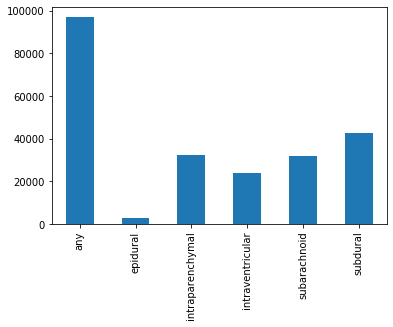

In [8]:
data[LABEL_COLUMN].sum().plot.bar()

In [9]:
if SAMPLE_FRAC < 1.0:
    data = data.sample(frac = SAMPLE_FRAC)

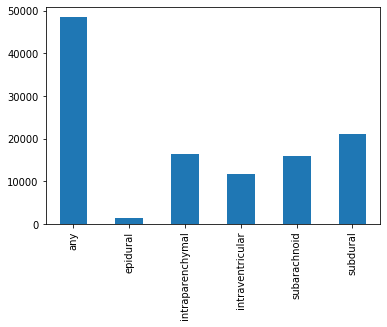

In [10]:
data[LABEL_COLUMN].sum().plot.bar()

### Calc Classes Weight

In [11]:
distrib_freq = data[LABEL_COLUMN].sum().to_numpy()
w_classes = distrib_freq.sum() / (NUM_CLASSES * distrib_freq)
w_classes

array([ 0.39598799, 13.9259125 ,  1.16698064,  1.62317922,  1.20445518,
        0.90940159])

### Check for Wrong Loss Function Choice

In [12]:
for l in LOSSES:
    if 'weight' in LOSS_LIST[l]:
        LOSS_LIST[l]['weight'] = torch.from_numpy(w_classes).to(device)
    else:
        raise Exception('You are trying to set weight in a loss function without weight parameter')

# Train Test Split

In [13]:
x = data.drop(LABEL_COLUMN, axis=1)
y = data[LABEL_COLUMN]

# Criando o dataframe de treine e teste com base no dataframe anteriormente criado
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = TEST_SPLIT, random_state = SEED)

# Data augmentation

In [14]:
train_transf = transforms.Compose([
    transforms.RandomRotation((0,360)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])

test_transf = transforms.Compose([
    transforms.ToTensor()
])

In [15]:
train_dataset = CustomDataset(X=X_train, 
                              y=y_train, 
                              img_folder=TRAIN_DIR,
                              img_ext=IMAGE_FORMAT, 
                              transform=train_transf)

test_dataset = CustomDataset(X=X_test, 
                             y=y_test, 
                             img_folder=TEST_DIR, 
                             img_ext=IMAGE_FORMAT,
                             transform=test_transf)

In [16]:
# Garregando os dados
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [17]:
dataloaders_dict = {'train': train_loader, 'val': test_loader}

# Model

In [18]:
def loadBestModel(model_name):
    # Get lastest model file
    list_of_files = glob.glob(MODEL_DIR + f'/*{model_name}*.pt') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    print(f'Loading model {latest_file}')
    model = torch.load(latest_file)
    return model

In [19]:
def getModel(model_name, num_classes):
    
    model_parameters = MODEL_LIST[model_name]
    
    if model_parameters['load_checkpoint']:
        
        model = loadBestModel(model_parameters['checkpoint_from'])
        
        for param in model.parameters():
            param.requires_grad = True
                    
    else:
        
        if model_parameters['base_model']=='densenet121':
            
            model = densenet121(pretrained=model_parameters['pretrained'])
            model.classifier = nn.Linear(1024, num_classes)   
            
        if model_parameters['base_model']=='vgg16':
            
            model = vgg16(pretrained=model_parameters['pretrained'])
            model.classifier[6] = nn.Linear(4096, num_classes) 
        
        if model_parameters['base_model']=='resnet50':
            
            model = resnet50(pretrained=model_parameters['pretrained'])
            model.fc = nn.Linear(2048, num_classes) 
            
        if model_parameters['base_model']=='inception_v3':
            
            model = inception_v3(pretrained=model_parameters['pretrained'])
            model.fc = nn.Linear(2048, num_classes) 
            model.AuxLogits.fc = nn.Linear(768, num_classes)
            
        elif model_parameters['base_model']=='efficientnetb7':
            
            model = EfficientNet.from_pretrained('efficientnet-b7')
            model._fc = nn.Linear(2560, NUM_CLASSES) 
            
        if (torch.cuda.device_count() > 1) & (not model_parameters['is_inception']):
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            model = nn.DataParallel(model) # When load checkpoint, the DataParallel is already in the model.
        
    for name, param in model.named_parameters():
        for l in model_parameters['layers_to_frozen']:
            if l in name:
                param.requires_grad = False

    if is_cuda:
        model = model.cuda()
        
    
        
    return model

# Optimizer

In [20]:
def getOptimizer(optimizer_name, model):

    params_to_update = []
    
    for name, param in model.named_parameters():
    
        if param.requires_grad == True:
        
            params_to_update.append(param)
            
            print("\t",name)

    opt_parameters = OPTIMIZER_LIST[optimizer_name]

    if opt_parameters['function'] == 'Adam':
        
        optimizer = torch.optim.Adam(params_to_update, 
                                     lr = opt_parameters['lr'],
                                     betas = opt_parameters['betas'],
                                     eps = opt_parameters['eps'],
                                     weight_decay = opt_parameters['weight_decay'],
                                     amsgrad = opt_parameters['amsgrad']
                                    )

    return optimizer

# Loss Function

In [21]:
def getLossFunction(loss_nme):
    
    loss_parameters = LOSS_LIST[loss_nme]

    if loss_parameters['function'] == 'SmoothL1Loss':
        criterion = nn.SmoothL1Loss(
            size_average = loss_parameters['size_average'],
            reduce = loss_parameters['reduce'],
            reduction = loss_parameters['reduction']
        )

    elif loss_parameters['function'] == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss(
            weight = loss_parameters['weight'],
            size_average = loss_parameters['size_average'],
            ignore_index = loss_parameters['ignore_index'],
            reduce = loss_parameters['reduce'],
            reduction = loss_parameters['reduction']
        )

    elif loss_parameters['function'] == 'NLLLoss':

        criterion = nn.NLLLoss(
            weight = loss_parameters['weight'],
            size_average = loss_parameters['size_average'],
            ignore_index = loss_parameters['ignore_index'],
            reduce = loss_parameters['reduce'],
            reduction = loss_parameters['reduction']
        )

    elif loss_parameters['function'] == 'QuadraticKappa':
        criterion = QuadraticKappa(
            n_classes = loss_parameters['n_classes']
        )
        
    elif loss_parameters['function'] == 'WeightedMultiLabelLogLoss':

        criterion = WeightedMultiLabelLogLoss(
            n_classes = loss_parameters['n_classes'],
            weight = loss_parameters['weight']
        )
        
    return criterion

# Train Function

In [22]:
def onehot(labels, num_classes):
    return torch.zeros(len(labels), num_classes).scatter_(1, labels.unsqueeze(1).cpu(), 1.).cuda()

def train_model(model, model_name, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):

    since = time.time()

    best_loss = 999
    
    print(model_name)
    print('-' * 100)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        epoch_since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            #running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        
                        outputs = torch.sigmoid(outputs)
                        aux_outputs = torch.sigmoid(aux_outputs)
                        
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                        
                    else:
                        
                        outputs = model(inputs)
                        outputs = torch.sigmoid(outputs)
                        
                        loss = criterion(outputs, labels)
                        
                    #_, preds = torch.max(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                #running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            #epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            #lr = optimizer.param_groups[0]['lr']

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # Write loss into Tensorboard
            tensorboard.add_scalar('Loss {}'.format(phase), epoch_loss, epoch)
            #tensorboard.add_scalar('Acc {}'.format(phase), epoch_acc, epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print('Saving the best model...')
                best_loss = epoch_loss
                torch.save(model, MODEL_DIR + '/' + model_name + '_imgsize' + str(INPUT_SIZE) + '_loss' + str(best_loss) + '.pt')
            
        epoch_time_elapsed = time.time() - epoch_since
        print('Epoch time elapsed: {:.0f}m {:.0f}s'.format(epoch_time_elapsed // 60, epoch_time_elapsed % 60))
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))
    print('')

    # load best model weights
    model = loadBestModel(model_name)
    return model, best_loss


# Grid Search

In [ ]:
model_name_list = []
metric_list = []

for m in MODELS:
    for o in OPTIMIZERS:
        for l in LOSSES:
            
            model = getModel(m, NUM_CLASSES)
            
            optimizer = getOptimizer(o, model)
            
            criterion = getLossFunction(l)
            
            model_name = f'{m}_{o}_{l}'
            
            tensorboard = SummaryWriter(comment = model_name)
            
            # Train and evaluate
            model, best_metric = train_model(
                model, 
                model_name, 
                dataloaders_dict, 
                criterion, 
                optimizer, 
                num_epochs=NUM_EPOCH, 
                is_inception=MODEL_LIST[m]['is_inception'])
            
            model_name_list.append(model_name)
            metric_list.append(best_metric)
            

Loading model /srv/app/data/models/FineTuningResNet50_DefaultAdam_WeightedMultiLabelLogLoss_imgsize299_loss0.15992117286916552.pt
	 module.conv1.weight
	 module.bn1.weight
	 module.bn1.bias
	 module.layer1.0.conv1.weight
	 module.layer1.0.bn1.weight
	 module.layer1.0.bn1.bias
	 module.layer1.0.conv2.weight
	 module.layer1.0.bn2.weight
	 module.layer1.0.bn2.bias
	 module.layer1.0.conv3.weight
	 module.layer1.0.bn3.weight
	 module.layer1.0.bn3.bias
	 module.layer1.0.downsample.0.weight
	 module.layer1.0.downsample.1.weight
	 module.layer1.0.downsample.1.bias
	 module.layer1.1.conv1.weight
	 module.layer1.1.bn1.weight
	 module.layer1.1.bn1.bias
	 module.layer1.1.conv2.weight
	 module.layer1.1.bn2.weight
	 module.layer1.1.bn2.bias
	 module.layer1.1.conv3.weight
	 module.layer1.1.bn3.weight
	 module.layer1.1.bn3.bias
	 module.layer1.2.conv1.weight
	 module.layer1.2.bn1.weight
	 module.layer1.2.bn1.bias
	 module.layer1.2.conv2.weight
	 module.layer1.2.bn2.weight
	 module.layer1.2.bn2.bias
	 

# The Best Model Metrics

In [ ]:
fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(metric_list))  # the x locations for the groups
ax.barh(ind, metric_list, width)
ax.set_yticks(ind+width/2)
ax.set_yticklabels(model_name_list, minor=False)
plt.xlabel('Loss')
for i, v in enumerate(metric_list):
    ax.text(v, i, str(v))

In [ ]:
print(model_name_list)
print(metric_list)

SAMPLE_FRAC = 0.01
['PreEfficientNet_DefaultAdam_WeightedMultiLabelLogLoss', 'PreDensenet121_DefaultAdam_WeightedMultiLabelLogLoss', 'PreVGG16_DefaultAdam_WeightedMultiLabelLogLoss', 'PreResNet50_DefaultAdam_WeightedMultiLabelLogLoss']
[0.2597252761325229, 0.18248862174864647, 0.1948435460864637, 0.18010420099840774]

SAMPLE_FRAC = 0.01
['PreEfficientNet_DefaultAdam_WeightedMultiLabelLogLoss', 'PreDensenet121_DefaultAdam_WeightedMultiLabelLogLoss', 'PreVGG16_DefaultAdam_WeightedMultiLabelLogLoss', 'PreResNet50_DefaultAdam_WeightedMultiLabelLogLoss']
[1.9888162942906151, 0.6419779309469817, 0.6130052950496551, 0.6645991335808494]


SAMPLE_FRAC = 0.10
['PreEfficientNet_DefaultAdam_WeightedMultiLabelLogLoss', 'PreDensenet121_DefaultAdam_WeightedMultiLabelLogLoss', 'PreVGG16_DefaultAdam_WeightedMultiLabelLogLoss', 'PreResNet50_DefaultAdam_WeightedMultiLabelLogLoss']
[2.0618010826537043, 0.5627026143388972, 0.5728568886494199, 0.5545951228073894]